In [ ]:
!pip install ultralytics

In [ ]:
!unzip /content/data.zip


In [ ]:
from ultralytics import YOLO
model = YOLO("/content/yolo11s-pose.pt")

# Train the model on the COCO8 example dataset for 100 epochs
results = model.train(data="/content/data/data.yaml", epochs=100, imgsz=512)


0: 512x512 1 gauge, 333.3ms
Speed: 4.3ms preprocess, 333.3ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)
🧭 Angle Debug:
🔸 Min angle: 169.90°
🔸 Max angle: 371.36°
🔸 Tip angle: 322.83°
📐 Angle span: 201.46°
📏 Normalized: 0.759
🎯 Pressure   : 6.83 bar


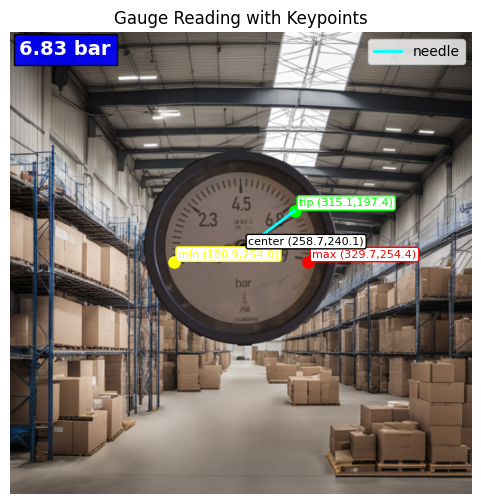

In [43]:
import numpy as np
import math
import matplotlib.pyplot as plt
from PIL import Image
from ultralytics import YOLO

# -------------------- Pressure Calculation Function -------------------- #
def calculate_pressure_from_keypoints(min_pt, max_pt, tip_pt, center_pt, min_pressure, max_pressure, debug=False):
    v_min = min_pt - center_pt
    v_max = max_pt - center_pt
    v_tip = tip_pt - center_pt

    def get_angle(v):
        return math.atan2(v[1], v[0])

    def normalize_angle(a):
        return a % (2 * math.pi)

    angle_min = normalize_angle(get_angle(v_min))
    angle_max = normalize_angle(get_angle(v_max))
    angle_tip = normalize_angle(get_angle(v_tip))

    if angle_max < angle_min:
        angle_max += 2 * math.pi
    if angle_tip < angle_min:
        angle_tip += 2 * math.pi

    angle_span = angle_max - angle_min
    relative_angle = angle_tip - angle_min
    normalized = np.clip(relative_angle / angle_span, 0, 1)
    pressure = min_pressure + normalized * (max_pressure - min_pressure)

    if debug:
        print("Angle Debug:")
        print(f"Min angle: {math.degrees(angle_min):.2f}°")
        print(f"Max angle: {math.degrees(angle_max):.2f}°")
        print(f"Tip angle: {math.degrees(angle_tip):.2f}°")
        print(f"Angle span: {math.degrees(angle_span):.2f}°")
        print(f"Normalized: {normalized:.3f}")
        print(f"Pressure   : {pressure:.2f} bar")

    return pressure

# -------------------- Inference + Visualization -------------------- #

# Load model and image
model = YOLO('/content/best.pt')  # Update as needed
img = Image.open('/content/v_0781_f_0000_rgba.png').convert("RGB")

# Predict keypoints
results = model(img, save=False)
kpts_tensor = results[0].keypoints.xy[0]
max_pt, min_pt, center_pt, tip_pt = [pt.cpu().numpy() for pt in kpts_tensor]

# Choose your gauge pressure range
min_pressure = 0
max_pressure = 9

# Calculate pressure
pressure = calculate_pressure_from_keypoints(
    min_pt=min_pt,
    max_pt=max_pt,
    tip_pt=tip_pt,
    center_pt=center_pt,
    min_pressure=min_pressure,
    max_pressure=max_pressure,
    debug=True
)

# -------------------- Visualization -------------------- #
plt.figure(figsize=(6, 6))
plt.imshow(img)
ax = plt.gca()

labels = ['max', 'min', 'center', 'tip']
colors = ['red', 'yellow', 'black', 'lime']
points = [max_pt, min_pt, center_pt, tip_pt]

# Plot keypoints with coordinate labels
for i, (x, y) in enumerate(points):
    ax.plot(x, y, 'o', color=colors[i], markersize=8)
    ax.text(x + 5, y - 5, f"{labels[i]} ({x:.1f},{y:.1f})",
            color=colors[i], fontsize=8,
            bbox=dict(facecolor='white', edgecolor=colors[i], boxstyle='round,pad=0.2'))

# Draw needle
plt.plot([center_pt[0], tip_pt[0]], [center_pt[1], tip_pt[1]],
         color='cyan', linewidth=2, label='needle')

# Show pressure reading
ax.text(10, 25, f"{pressure:.2f} bar", fontsize=14, color='white', weight='bold',
        bbox=dict(facecolor='blue', alpha=0.9))

plt.axis("off")
plt.title("Gauge Reading with Keypoints")
plt.legend()
plt.show()


Traditional Image processing

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

# ---------- Step 1: Load and preprocess image ----------
image_path = "/content/v_0871_f_0000_rgba.png"
img = cv2.imread(image_path)
height, width = img.shape[:2]

# Focus on bottom half where gauge is expected
bottom_half = img[height // 2:, :]
gray = cv2.cvtColor(bottom_half, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# ---------- Step 2: Detect circular dial ----------
circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=100,
                           param1=50, param2=25, minRadius=60, maxRadius=200)

if circles is not None:
    circles = np.uint16(np.around(circles))
    x, y, r = circles[0][0]
    dial_center = np.array([x, y])

    # ---------- Step 3: Detect needle ----------
    edges = cv2.Canny(blurred, 50, 150)
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=50,
                            minLineLength=60, maxLineGap=10)

    needle_line = None
    max_len = 0
    needle_img = bottom_half.copy()

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            pt1 = np.array([x1, y1])
            pt2 = np.array([x2, y2])
            d1 = np.linalg.norm(pt1 - dial_center)
            d2 = np.linalg.norm(pt2 - dial_center)

            if d1 < 30 or d2 < 30:
                length = np.linalg.norm(pt1 - pt2)
                if length > max_len:
                    max_len = length
                    needle_line = (pt1, pt2)

    if needle_line:
        # Draw the needle
        cv2.line(needle_img, tuple(needle_line[0]), tuple(needle_line[1]), (255, 0, 0), 2)

        # ---------- Step 4: Calculate angle ----------
        pt1, pt2 = needle_line
        angle = math.degrees(math.atan2(-(pt2[1] - pt1[1]), pt2[0] - pt1[0]))
        if angle < 0:
            angle += 360

        # ---------- Step 5: Estimate pressure ----------
        def angle_to_pressure(angle, min_angle, max_angle, min_val, max_val):
            if max_angle < min_angle:
                max_angle += 360
            if angle < min_angle:
                angle += 360
            ratio = (angle - min_angle) / (max_angle - min_angle)
            return min_val + ratio * (max_val - min_val)

        # Set tick positions
        min_tick_angle = 135  # 0 bar
        max_tick_angle = -45  # 10 bar (becomes 315° after wrap)
        pressure = angle_to_pressure(angle, min_tick_angle, max_tick_angle, 0, 10)

        # ---------- Step 6: Visualize ----------
        cx, cy = dial_center
        plt.figure(figsize=(6, 6))
        plt.imshow(cv2.cvtColor(needle_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Pressure: {pressure:.2f} bar  (Angle: {angle:.2f}°)")
        plt.scatter([cx], [cy], c='red', s=50, label='Center')
        plt.axis("off")
        plt.legend()
        plt.show()
    else:
        print("❌ Needle not detected.")
else:
    print("❌ Dial not detected.")


❌ Needle not detected.
